# Imports

In [1]:
import re
import copy
import string
import itertools
import pickle
import pandas as pd
import numpy as np
import fasttext, nltk   # NLP library
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

RAW_DATA_FOLDER = '../data/raw/'
PROCESSED_DATA_FOLDER = '../data/processed/'
DATASET = 'BeerAdvocate/'    # Can be either 'BeerAdvocate/' or 'RateBeer/'

/opt/miniconda3/envs/ada_project/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load Data

In [2]:
reviews = pd.read_pickle(PROCESSED_DATA_FOLDER + DATASET + 'reviews.pkl')
beers = pd.read_pickle(PROCESSED_DATA_FOLDER + DATASET + 'beers.pkl')

# Make sure there are no duplicates on the primary key
reviews.drop_duplicates(subset=['beer_id', 'user_id', 'date'], inplace=True)
beers.drop_duplicates(subset=['beer_id'], inplace=True)

# Beer style to supra beer style

In [3]:
style_features = {}
style_features['Pale Ales'] = ["amber ale", "american pale ale", "english pale ale", "blonde ale", "bitter"]
style_features['Dark Lagers'] = ["amber lager", "dunkel", "marzen", "oktoberfest", "schwarzbier", "vienna lager", "dark lager", "red lager"]
style_features['Brown Ales'] = ["brown ale", "mild"]
style_features['India Pale Ales'] = ["ipa", "indian pale ale"]
style_features['Wheat Beers'] = ["wheat wine ale", "wheat", "witbier", "weisse", "weissbier", "dunkelweizen", "hefeweizen", "kristalweizen"]
style_features['Strong Ales'] = ["barley wine", "barleywine",  "imperial red ale", "barley wine ale", "old ale", "strong ale", "strong pale ale"]
style_features['Belgian Styles'] = ["belgian blonde ale", "dubbel", "belgian strong dark ale", "belgian dark ale", "golden strong ale", "belgian pale ale", "quadrupel", "saison", "tripel"]
style_features['Hybrid Beers'] = ["cream ale", "biere de garde", "bière de garde", "common", "altbier", "kolsch", "kölsch", "red beer", "red ale"]
style_features['Porters'] = ["porter"]
style_features['Stouts'] = ["stout"]
style_features['Bocks'] = ["bock", "doppelbock", "maibock", "weizenbock"]
style_features['Scottish-Style Ales'] = ["heavy", "scottish ale"]
style_features['Wild/Sour Beers'] = ["brett", "sour", "flanders", "lambic", "faro", "gueuze", "gose", "wild"]
style_features['Pilseners and Pale Lagers'] = ["pale lager", "american Lager", "american adjunct lager", "pilsener", "pilsner", "export", "helles"]
style_features['Specialty Beers'] = ["black ale", "barrel-aged", "chocolate", "coffee", "fruit", "field", "craft", "herb", "spice", "honey", "pumpkin", "rye", "roggenbier", "session", "smoke", "rauchbier", "specialty", "sahti"]

In [4]:
beers['supra_style'] = beers['style'].apply(lambda x: x + 'undefined')

for supra_style, features in style_features.items():
    for feature in features:
        beers['supra_style'] = beers['supra_style'].apply(lambda x: supra_style if feature in x.lower() else x)

beers['supra_style'] = beers['supra_style'].apply(lambda x: 'Undefined' if 'undefined' in x.lower() else x)

style_to_supra = {}
for style, groups in beers.groupby('style'):
    style_to_supra[style] = groups.supra_style.iloc[0]

# What are the adjectives that best describe each beer style?

In order to help the consumers to choose a beer that would fit their tastes, we try to provide, for each main beer styles, a list of adjectives that best describe the style. 

To determine which adjectives best describe each style, we carry out a lexical analysis based on textual reviews. For a given beer style, the most informatives adjectives are those that occure the most in the textual reviews about the given beer style, but that does not occure to much in reviews of other beer style. To adjust for the fact that some adjectives appear more frequently in general (for example 'good' or 'bad'), we will use a TF-IDF approach, as it is one of the most popular term-weighting schemes today.

This lexical analysis can be decomposed in the following steps:

- Step 1: Group reviews by language.
- Step 2: Group reviews by beer styles.
- Step 3: Extract adjectives from the textual reviews.
- Step 4: Group adjectives by supra style.
- Step 5: Compute the TF-IDF matrix where the documents are the list of adjectives for each supra styles.
- Step 6: Visualize the most informatives adjectives per supra style.

In the following lexical analysis one of the main assumption is that most of the adjectives in the reviews are actually used to describe the beer.

### Step 1: Group reviews by language

To group the reviews by language, a pre-trained language predictor provided by fastText library is used. If one wants to reproduce the following language classification, first make sure to have all the requirements (see requirements.txt in the root of the repository), then download the pre-trained language predictor [here](https://fasttext.cc/docs/en/language-identification.html) and place it in the `/src` folder.

In [5]:
class LanguagePredictor:
    def __init__(self):
        pretrained_lang_model = "../src/lid.176.bin"
        self.model = fasttext.load_model(pretrained_lang_model)

    def predict_lang(self, text):
        predictions = self.model.predict(text)
        language = re.sub(pattern='__label__', repl='', string=predictions[0][0])
        score = predictions[1][0]
        return language, score

In [6]:
model = LanguagePredictor()
reviews['language'] = reviews.text.apply(lambda x: model.predict_lang(x)[0])
reviews['score_language'] = reviews.text.apply(lambda x: model.predict_lang(x)[1])
reviews.head()

,beer_id,user_id,date,text,language,score_language
0,142544,nmann08.184925,2015-08-20 10:00:00,"From a bottle, pours a piss yellow color with ...",en,0.891358
1,19590,stjamesgate.163714,2009-02-20 11:00:00,Pours pale copper with a thin head that quickl...,en,0.924852
2,19590,mdagnew.19527,2006-03-13 11:00:00,"500ml Bottle bought from The Vintage, Antrim.....",en,0.783006
3,19590,helloloser12345.10867,2004-12-01 11:00:00,Serving: 500ml brown bottlePour: Good head wit...,en,0.852789
4,19590,cypressbob.3708,2004-08-30 10:00:00,"500ml bottlePours with a light, slightly hazy ...",en,0.768192


In [7]:
language_count = reviews.groupby('language').text.count().sort_values(ascending=False).rename('Number of reviews')
language_count.head()

language
en    2589044
fr        344
es         64
pt         40
fi         34
Name: Number of reviews, dtype: int64

In [8]:
nb_reviews = len(reviews)
nb_reviews_low_lang_score = len(reviews[reviews.score_language < 0.9])

print("Percentage of reviews with language score bellow 0.9: {:.2f}%".format(100*nb_reviews_low_lang_score/nb_reviews))

Percentage of reviews with language score bellow 0.9: 14.95%


Regarding the number of reviews in each language, the rest of the analysis will be done only on english reviews as there are not enough reviews for other language.

Also, only reviews with a score language (confidence of the sentence belonging to the predicted language) greater or equal than 0.9 are considered. Doing so we throw away less than 15% of the reviews but we make sure to keep only reviews in the same language with high confidence and by the same time we discard dirty reviews (empty reviews, reviews with several languages ...etc..).

In [9]:
LANGUAGE = 'en'
reviews = reviews[(reviews.language == LANGUAGE) & (reviews.score_language >= 0.9)]

### Step 2: Group reviews by beer styles

In order to group the reviews by beer styles we first join the relations `beers` and `reviews` on `beer_id` key, we select `text` and `style` attributes and then we finally group the merged dataframe by `style`. Since the beer styles will be used as name of the files we storing the adjectives, we need to format them (replace `/` and spaces).

In [10]:
merged = reviews.merge(beers, on='beer_id')[['text', 'style']]
merged['style'] = merged['style'].apply(lambda x: x.replace('/', ' ').replace('-', ' '))
merged['style'] = merged['style'].apply(lambda x: ' '.join(x.split()).replace(' ', '_'))
styles = merged['style'].unique()
style_groups = merged.groupby('style')

### Step 3: Extract adjectives from the textual reviews

First the reviews of each beer style are tokenized using the tokenizer provided by `nltk` package. Then the Part-Of-Speech tagger from the same package is applied on each tokenized reviews. The adjectives are the token with the tag `JJ`. Adjectives used in reviews of the same beer style are then stored as a list of string (`adjectives` variable). Since it takes a while to tag the tokens, the intermediate variable `adjectives` is stored in text files for each beer style. This allow the adjectives extraction to be done to be done iteratively, and only once.

In order to improve efficiency punctuations and stopwords are removed before the Part-Of-Speech tagging. Also, caching the stopwords object imported from `nltk` package allow to speed up the process.

Be aware that the following cell is long to run (more than 1h on MacBook M1 Pro). Since the adjectives have already been stored, it is not necessary to run the following cell.

In [11]:
cachedStopWords = stopwords.words("english")

for style in styles:
    normalized = style_groups.get_group(style).text.str.lower().apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    tokens = normalized.apply(nltk.word_tokenize).tolist()
    
    for i in range(len(tokens)):
        tokens[i] = [word for word in tokens[i] if word not in cachedStopWords]
    
    tagged_tokens = nltk.pos_tag_sents(tokens)
    adjectives = [word for (word, tag) in list(itertools.chain.from_iterable(tagged_tokens)) if tag == 'JJ']
    
    with open(PROCESSED_DATA_FOLDER + DATASET + 'adjectives/{}.txt'.format(style), 'w') as f:
        f.writelines('\n'.join(adjectives))

### Step 4: Group adjectives by supra style

Given the mapping from beer style to supra beer style computed in the previous sections we can group the adjectives from the same supra beer style. We need to first transform the beer styles to match the format name used to store the adjectives. 

In [2]:
formated_style_to_supra = copy.deepcopy(style_to_supra)

for style, supra_style in style_to_supra.items():
    formated_style = style.replace('/', ' ').replace('-', ' ')
    formated_style = ' '.join(formated_style.split()).replace(' ', '_')
    formated_style_to_supra[formated_style] = style_to_supra[style]
    if style != formated_style:
        del formated_style_to_supra[style]

corpus = {key: [] for key in formated_style_to_supra.values()}
for style in styles:
    with open(PROCESSED_DATA_FOLDER + DATASET + 'adjectives/{}.txt'.format(style), 'r') as f:
        adjectives = f.read().splitlines()
    corpus[formated_style_to_supra[style]].extend(adjectives)

corpus = {key: ' '.join(adjectives) for key, adjectives in corpus.items()}

NameError: name 'style_to_supra' is not defined

### Step 5: Compute the TF-IDF matrix

In this step we aim at retrieving the adjectives that are the most informatives for each beer styles. 

As said before, for a given beer style, the most informatives adjectives are those that occure the most in the reviews, but we want to give less importance to the adjectives that frequently appear in every styles. To adjust for the fact that some adjectives appear more frequently in general (for example 'good' or 'bad'), we use a TF-IDF approach, as it is one of the most popular term-weighting schemes today. Here the terms are the adjectives and the documents are the adjectives belonging to the same beer style. 

From [WikiPedia](https://en.wikipedia.org/wiki/Tf%E2%80%93idf):
The term frequency (tf) is the relative frequency of term t within document d and it is computed as follow:

$$ \operatorname{tf}(t, d)=\frac{f_{t, d}}{\sum_{t^{\prime} \in d} f_{t^{\prime}, d}} $$

where $f_{t, d}$ is the raw count of a term in a document, i.e., the number of times that term $t$ occurs in document $d$. Note the denominator is simply the total number of terms in document $d$ (counting each occurrence of the same term separately).

One the other hand, the inverse document frequency (idf) is a measure of how much information the word provides, i.e., if it is common or rare across all documents, and it is computed ad follow:

$$ \qquad \operatorname{idf}(t, D)=-\log \frac{n_t}{N} $$

with
- $N$ : total number of documents in the corpus $N=|D|$
- $n_t$ : number of documents where the term $t$ appears (i.e., $\operatorname{tf}(t, d) \neq 0$ ). If the term is not in the corpus, this will lead to a division-by-zero. It is therefore common to adjust the numerator to $1+n_t$.

Then tf-idf is calculated as
$$
\operatorname{tfidf}(t, d, D)=\operatorname{tf}(t, d) \cdot \operatorname{idf}(t, D)
$$
A high weight in tf-idf is reached by a high term frequency (in the given document) and a low document frequency of the term in the whole collection of documents; the weights hence tend to filter out common terms. Since the ratio inside the idf's log function is always greater than or equal to 1 , the value of idf (and tf-idf) is greater than or equal to 0 . As a term appears in more documents, the ratio inside the logarithm approaches 1 , bringing the idf and tf-idf closer to 0 .

To compute the TF-IDF matrix, `TfidfVectorizer` from `Scikit-Learn` package is used. The `Scikit-Learn` implementation of the TF-IDF matrix is slightly different than the one presented above as the idf term is computed as follow:
$$
\qquad \operatorname{idf}(t, D)=-\log \frac{n_t}{N} + 1
$$
The effect of adding “1” to the idf in the equation above is that terms with zero idf, i.e., terms that occur in all documents, will not be entirely ignored.

In [79]:
vectorizer = TfidfVectorizer(use_idf=True)
X = vectorizer.fit_transform(list(corpus.values()))

feature_names = vectorizer.get_feature_names()
TF_IDF = pd.DataFrame(X.todense().tolist(), index=list(corpus.keys()), columns=feature_names)

/opt/miniconda3/envs/ada_project/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Step 6: Visualize the most informatives adjectives per supra style

After inpsecting the results it appeared that some irrelevant adjectives still had a high tf-idf terms. This is due to the fact that the implementation of `Scikit-Learn` does not completly ignore the terms that appear in all documents. And here some words appear in all documents and with a very high tf term. Therefore the idf term is not enough to compensate the tf term and it results in a high tf-idf term. We choosed to manually remove those adjectives, and we show the 20 most informatives adjectives (based on the tf-idf weight) as a word cloud where the size of the word are proportional to the associated tf-idf term.

In [80]:
TF_IDF.drop(columns=['good', 'nice', 'bad', 'great'], inplace=True)
TF_IDF.drop(columns=['little', 'big', 'small'], inplace=True)
TF_IDF.drop(columns=['overall', 'much', 'nose'], inplace=True)
TF_IDF.drop(columns=['drinkable', 'decent', 'easy'], inplace=True)

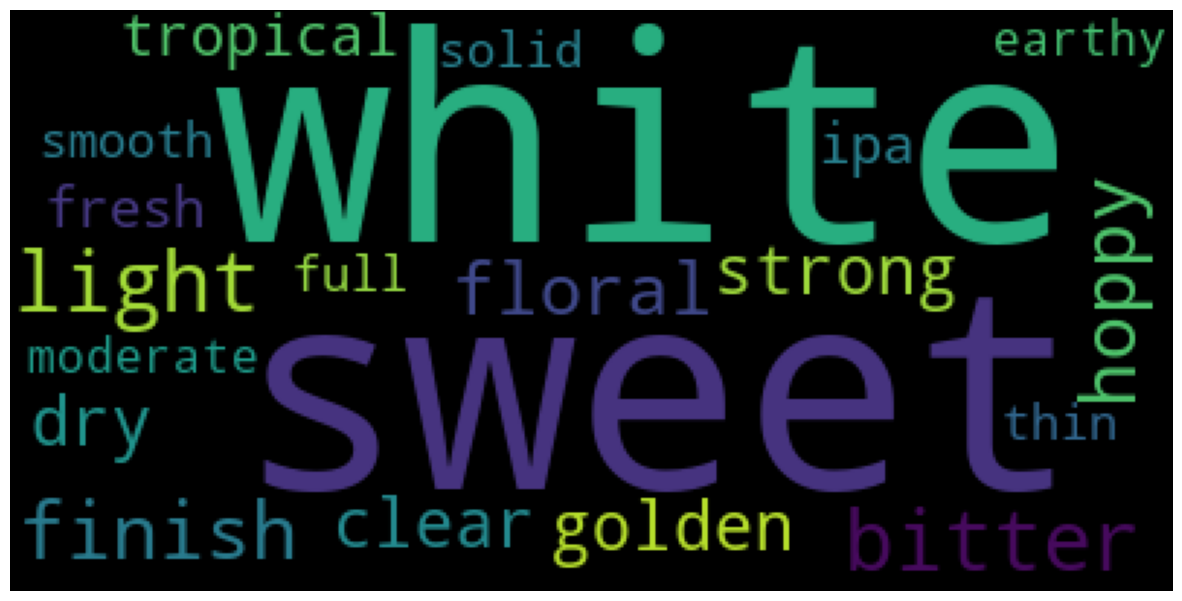

In [82]:
wordcloud = WordCloud(background_color="white", max_words=20).generate_from_frequencies(TF_IDF.loc['India Pale Ales'])

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()